# BBC News Text Classification

## Background
In this machine learning project, the overall topic that will be resolved is in the field of news classification, where it will try to predict the news category whether it's a business, entertainment, politics, sports, or tech topic based on the text news.

## 1. Download and import the required library

### 1.1 Download the required library

In [1]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### 1.2 Import the required libraries

In [2]:
# library for prepare the dataset
import os
import zipfile

# library for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# library for data processing
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# library for modeling
import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense, SpatialDropout1D

## 2. Data Preparation

### 2.1 Prepare Kaggle credential

In [3]:
# set the Kaggle credential

os.environ['KAGGLE_USERNAME'] = 'rifqinovandi'
os.environ['KAGGLE_KEY'] = '1480a0d3001fda1784e2e9930f358102'

### 2.2 Download and preprocess dataset

In [4]:
# Download the dataset with Kaggle CLI
!kaggle datasets download -d balatmak/newsgroup20bbcnews

 46% 7.00M/15.1M [00:00<00:00, 70.7MB/s]
100% 15.1M/15.1M [00:00<00:00, 116MB/s] 


In [5]:
# Extract zip file to CWD
files = "/content/newsgroup20bbcnews.zip"
zip = zipfile.ZipFile(files, 'r')
zip.extractall('/content')
zip.close()

## 3. Data Understanding

### 3.1 Read dataset with pandas

In [6]:
# Read dataset with pandas

news_df = pd.read_csv('/content/bbc-text.csv')
news_df

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
...,...,...
2220,business,cars pull down us retail figures us retail sal...
2221,politics,kilroy unveils immigration policy ex-chatshow ...
2222,entertainment,rem announce new glasgow concert us band rem h...
2223,politics,how political squabbles snowball it s become c...


In [7]:
print(news_df['text'][1])

worldcom boss  left books alone  former worldcom boss bernie ebbers  who is accused of overseeing an $11bn (£5.8bn) fraud  never made accounting decisions  a witness has told jurors.  david myers made the comments under questioning by defence lawyers who have been arguing that mr ebbers was not responsible for worldcom s problems. the phone company collapsed in 2002 and prosecutors claim that losses were hidden to protect the firm s shares. mr myers has already pleaded guilty to fraud and is assisting prosecutors.  on monday  defence lawyer reid weingarten tried to distance his client from the allegations. during cross examination  he asked mr myers if he ever knew mr ebbers  make an accounting decision  .  not that i am aware of   mr myers replied.  did you ever know mr ebbers to make an accounting entry into worldcom books   mr weingarten pressed.  no   replied the witness. mr myers has admitted that he ordered false accounting entries at the request of former worldcom chief financia

### 3.2 Explore dataset information

In [8]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [9]:
# check for missing values
news_df.isna().sum()

category    0
text        0
dtype: int64

In [10]:
# check for duplicate row
news_df.duplicated().sum()

99

### 3.3 Data visualization

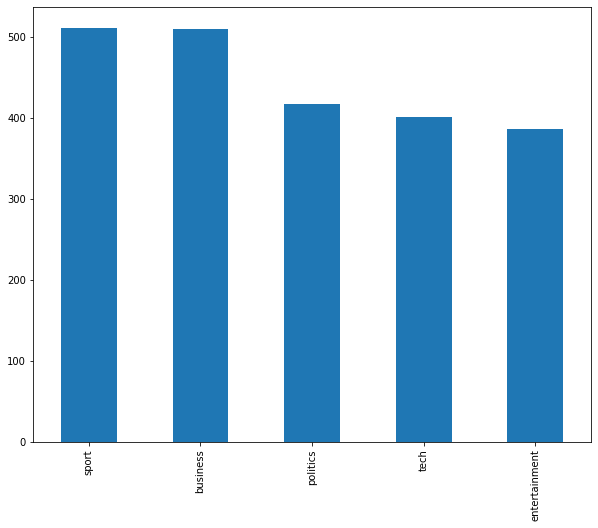

In [11]:
news_df['category'].value_counts().plot(kind='bar', figsize=(10, 8))

### 3.4 Clean text from stopwords and symbols

In [12]:
# download nltk stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [13]:
# create function to clean text from stopwords and symbols using regex and nltk

space = re.compile('[/(){}\[\]\|@,;]')
symbols= re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = space.sub(' ', text) 
    text = symbols.sub('', text)
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

In [14]:
# applying function to pandas df

news_df['text'] = news_df['text'].apply(clean_text)

### 3.5 Visualize most common text in WordCloud

In [15]:
# create WordCloud function

def wordCloud(words):
  wordCloud = WordCloud(width=800, height=500, background_color='white', random_state=21, max_font_size=120).generate(words)

  plt.figure(figsize=(10, 7))
  plt.imshow(wordCloud, interpolation='bilinear')
  plt.axis('off')

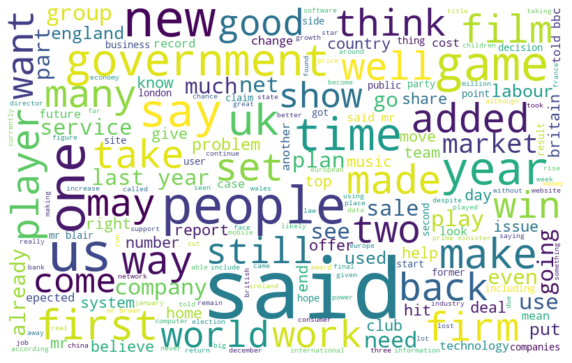

In [16]:
# visualize WordCloud for all category

all_words = ' '.join([text for text in news_df['text']])
wordCloud(all_words)

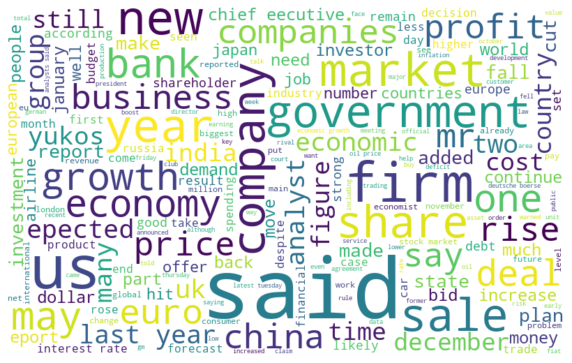

In [17]:
# visualize WordCloud for business category news

business = ' '.join(text for text in news_df['text'][news_df['category']=='business'])
wordCloud(business)

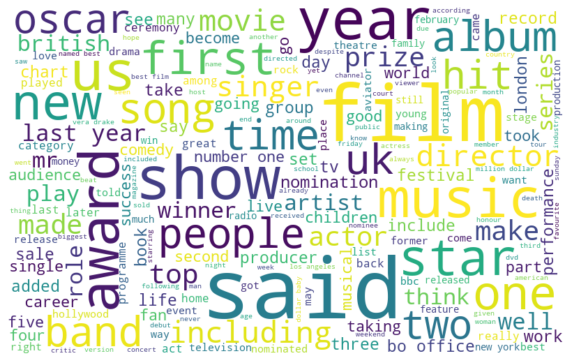

In [18]:
# visualize WordCloud for entertainment category news

entertainment = ' '.join(text for text in news_df['text'][news_df['category']=='entertainment'])
wordCloud(entertainment)

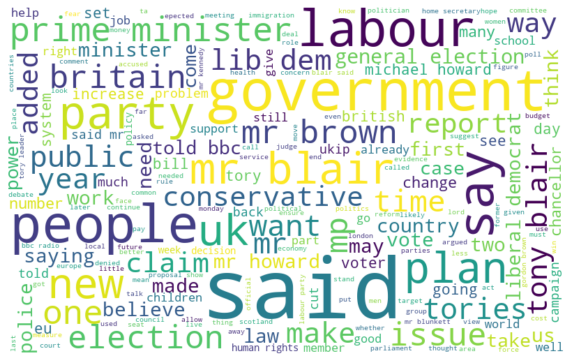

In [19]:
# visualize WordCloud for politics category news

politics = ' '.join(text for text in news_df['text'][news_df['category']=='politics'])
wordCloud(politics)

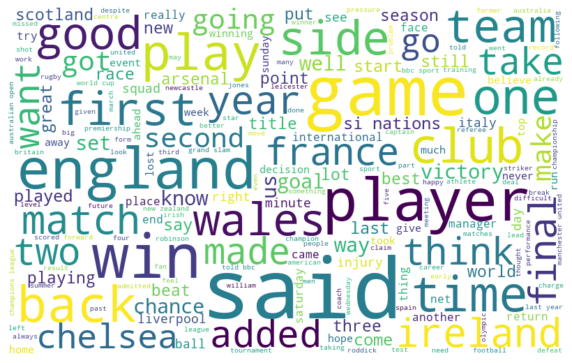

In [20]:
# visualize WordCloud for sport category news

sport = ' '.join(text for text in news_df['text'][news_df['category']=='sport'])
wordCloud(sport)

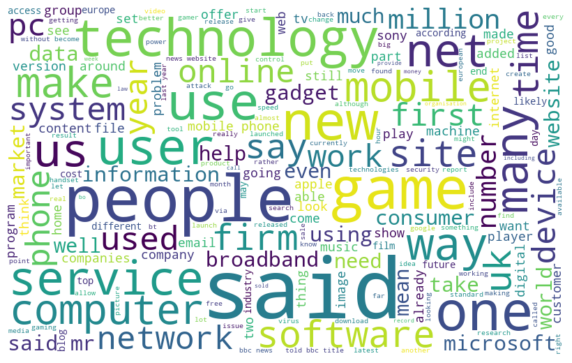

In [21]:
# visualize WordCloud for tech category news

tech = ' '.join(text for text in news_df['text'][news_df['category']=='tech'])
wordCloud(tech)

Since the word 'said' is always dominating our WordCloud, we can remove that word later to improve our model accuracy

## 4. Data Preparation

### 4.1 Clean duplicated and unecessary word in data

In [22]:
news_df = news_df.drop_duplicates()

In [23]:
news_df.duplicated().sum()

0

In [24]:
news_df['text'] = [re.sub('said', '', x) for x in news_df['text']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### 4.2 Using one hot encoding for category column

In [25]:
category = pd.get_dummies(news_df['category'])
news_fixed = pd.concat([news_df, category], axis=1)
news_fixed = news_fixed.drop(columns='category')
news_fixed

,text,business,entertainment,politics,sport,tech
0,tv future hands viewers home theatre systems p...,0,0,0,0,1
1,worldcom boss left books alone former worldcom...,1,0,0,0,0
2,tigers wary farrell gamble leicester say rushe...,0,0,0,1,0
3,yeading face newcastle fa cup premiership side...,0,0,0,1,0
4,ocean twelve raids bo office ocean twelve crim...,0,1,0,0,0
...,...,...,...,...,...,...
2220,cars pull us retail figures us retail sales fe...,1,0,0,0,0
2221,kilroy unveils immigration policy echatshow ho...,0,0,1,0,0
2222,rem announce new glasgow concert us band rem a...,0,1,0,0,0
2223,political squabbles snowball become commonplac...,0,0,1,0,0


### 4.3 Split train and test data

In [26]:
text = news_fixed['text'].values
label = news_fixed[['business', 'entertainment', 'politics', 'sport', 'tech']].values

In [27]:
# Train test split data

text_train, text_test, label_train, label_test = train_test_split(text, label, test_size=0.2)

### 4.4 Pre-modeling steps

In [28]:
# set the necessary variables

vocab_size = 30000
embedding_dim = 100
max_length = 3000
trunc_type='post'
oov_tok = "<OOV>"

In [29]:
# using text preprocessing tokenizer and sequence preprocessing padsequences

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(text_train)
tokenizer.fit_on_texts(text_test)

train_sequences = tokenizer.texts_to_sequences(text_train)
test_sequences = tokenizer.texts_to_sequences(text_test)
 
train_padsequences = pad_sequences(train_sequences, maxlen=max_length, truncating=trunc_type)
test_padsequences = pad_sequences(test_sequences, maxlen=max_length)

## 5. Modeling

### 5.1 Using Sequential model

In [30]:
# using sequential model with embedding, LSTM, and Dense layers

model = Sequential([
                    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
                    SpatialDropout1D(0.5),
                    LSTM(64, dropout=0.4, recurrent_dropout=0.4),
                    Dropout(0.5),
                    Dense(5, activation='softmax')
                    ])

### 5.2 Compile model

In [31]:
# Compile model

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

### 5.3 Create callback class

In [32]:
# Add calbacks on_epoch_end

class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.96 and logs.get('val_accuracy')>0.96):
      print("\nModel accuracy and validation accuracy > 96%!")
      self.model.stop_training = True
callbacks = myCallback()

### 5.4 Fit model

In [33]:
# Fit model

hist = model.fit(
    train_padsequences,
    label_train,
    epochs=10,
    validation_data=(test_padsequences, label_test),
    callbacks=[callbacks]
)

Epoch 1/10
53/53 [==============================] - 242s 4s/step - loss: 1.5995 - accuracy: 0.2583 - val_loss: 1.5779 - val_accuracy: 0.3892
Epoch 2/10
53/53 [==============================] - 223s 4s/step - loss: 1.3115 - accuracy: 0.4399 - val_loss: 0.9162 - val_accuracy: 0.6250
Epoch 3/10
53/53 [==============================] - 222s 4s/step - loss: 0.8180 - accuracy: 0.6651 - val_loss: 0.5849 - val_accuracy: 0.7264
Epoch 4/10
53/53 [==============================] - 224s 4s/step - loss: 0.5328 - accuracy: 0.8084 - val_loss: 0.4847 - val_accuracy: 0.8491
Epoch 5/10
53/53 [==============================] - 222s 4s/step - loss: 0.4235 - accuracy: 0.8603 - val_loss: 0.5040 - val_accuracy: 0.8561
Epoch 6/10
53/53 [==============================] - 223s 4s/step - loss: 0.3191 - accuracy: 0.9263 - val_loss: 0.3009 - val_accuracy: 0.9292
Epoch 7/10
53/53 [==============================] - 223s 4s/step - loss: 0.1809 - accuracy: 0.9652 - val_loss: 0.3984 - val_accuracy: 0.8585
Epoch 8/10
53

## 6. Model Evaluation

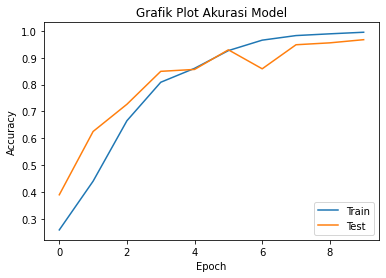

In [34]:
# Plot accuracy and loss model

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Grafik Plot Akurasi Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

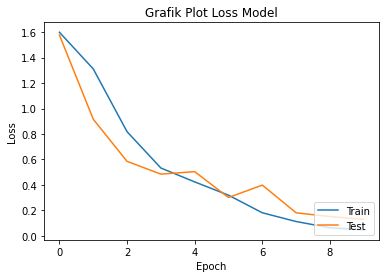

In [35]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Grafik Plot Loss Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()